# Import Required Libraries

In [244]:
import re
import gensim
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
nltk.download('stopwords')
nltk.download('punkt')
from wordcloud import WordCloud
import warnings
warnings.filterwarnings('ignore')
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, Bidirectional, Conv1D, MaxPool1D, Dropout
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from keras.callbacks import EarlyStopping

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


# Load Data into Dataframes

In [178]:
# Load fake news csv file into pandas dataframe and list first 10 rows
fake_news_dataframe = pd.read_csv('fake.csv')
fake_news_dataframe.head(10)

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"
5,Racist Alabama Cops Brutalize Black Boy While...,The number of cases of cops brutalizing and ki...,News,"December 25, 2017"
6,"Fresh Off The Golf Course, Trump Lashes Out A...",Donald Trump spent a good portion of his day a...,News,"December 23, 2017"
7,Trump Said Some INSANELY Racist Stuff Inside ...,In the wake of yet another court decision that...,News,"December 23, 2017"
8,Former CIA Director Slams Trump Over UN Bully...,Many people have raised the alarm regarding th...,News,"December 22, 2017"
9,WATCH: Brand-New Pro-Trump Ad Features So Muc...,Just when you might have thought we d get a br...,News,"December 21, 2017"


In [179]:
# counting the number of total fake news for each category of news like politics, Government, US_news
for subject,count in fake_news_dataframe.subject.value_counts().iteritems():
    print("{}: {}".format(subject,count))
    
print("Total Rows:{}".format(fake_news_dataframe.shape[0]))

News: 9050
politics: 6841
left-news: 4459
Government News: 1570
US_News: 783
Middle-east: 778
Total Rows:23481


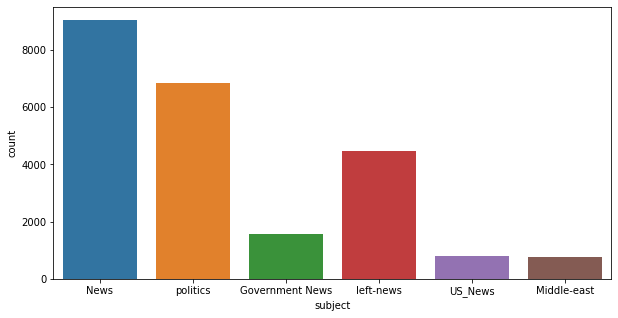

In [180]:
# plot bar graph and word cloud of fake news dataframe
plt.figure(figsize=(10,5))
sns.countplot("subject", data=fake_news_dataframe)
plt.show()

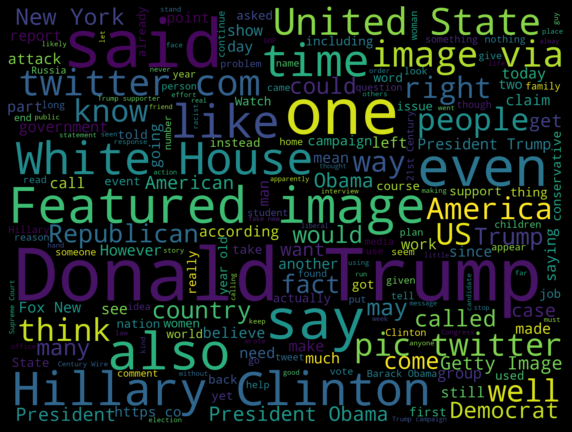

In [181]:
# plot word cloud of fake news dataframe
text = ''
for news in fake_news_dataframe.text.values:
    text += f" {news}"
wordcloud = WordCloud(width = 2000, height = 1500, background_color = 'black', stopwords = set(nltk.corpus.stopwords.words("english"))).generate(text)
fig = plt.figure(figsize = (10, 8), facecolor = 'k', edgecolor = 'k')
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.show()

In [182]:
# Load real.csv into panda dataframe and list firdt 10 rows
real_news_dataframe = pd.read_csv('true.csv')
real_news_dataframe.head(10)

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"
5,"White House, Congress prepare for talks on spe...","WEST PALM BEACH, Fla./WASHINGTON (Reuters) - T...",politicsNews,"December 29, 2017"
6,"Trump says Russia probe will be fair, but time...","WEST PALM BEACH, Fla (Reuters) - President Don...",politicsNews,"December 29, 2017"
7,Factbox: Trump on Twitter (Dec 29) - Approval ...,The following statements were posted to the ve...,politicsNews,"December 29, 2017"
8,Trump on Twitter (Dec 28) - Global Warming,The following statements were posted to the ve...,politicsNews,"December 29, 2017"
9,Alabama official to certify Senator-elect Jone...,WASHINGTON (Reuters) - Alabama Secretary of St...,politicsNews,"December 28, 2017"


In [183]:
# counting the number of total real news for each category of news like politics, Government, US_news
for subject,count in real_news_dataframe.subject.value_counts().iteritems():
    print("{}: {}".format(subject,count))
    
print("Total Rows:{}".format(real_news_dataframe.shape[0]))

politicsNews: 11272
worldnews: 10145
Total Rows:21417


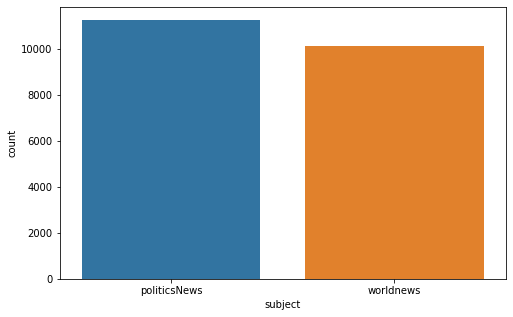

In [184]:
# plot bar graph of fake news dataframe
plt.figure(figsize=(8,5))
sns.countplot("subject", data=real_news_dataframe)
plt.show()

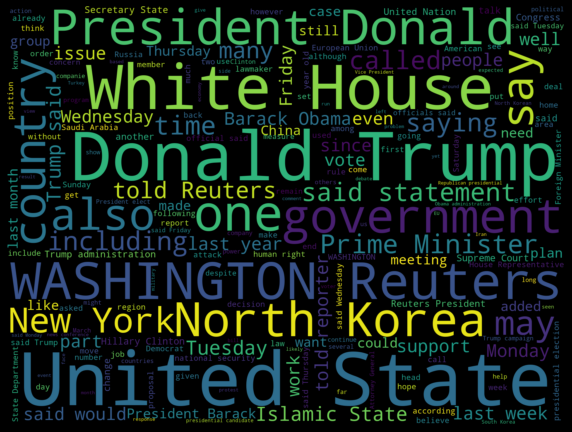

In [185]:
# plot word cloud of real news dataframe
text = ''
for news in real_news_dataframe.text.values:
    text += f" {news}"
wordcloud = WordCloud(width = 2000, height = 1500, background_color = 'black', stopwords = set(nltk.corpus.stopwords.words("english"))).generate(text)
fig = plt.figure(figsize = (10, 8), facecolor = 'k', edgecolor = 'k')
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.show()

In [186]:
# getting the shape of both the dataframes
print("Fake News dataframe size: {}".format(fake_news_dataframe.shape))
print("Real News dataframe size: {}".format(real_news_dataframe.shape))

Fake News dataframe size: (23481, 4)
Real News dataframe size: (21417, 4)


## Text Comparison of fake news and real news dataframe
Most of the text contains reuters information. Also Some of the texts are from Twitter and not all texts contain publication information.\
Real news dataframe have source of publication but same is absent in fake news dataframe

# Clean Data


In [188]:
# create a list of indices that do not have publication part
# to do this we will split the text with '-'' delimeter and check if the later part is empty or not 
# and also check if text size is greater than 260 words(because maximum tweet size is 260 words)
publisher = []
tmp_text = []
unknown_publishers = []
for index,row in enumerate(real_news_dataframe.text.values):
    try:
        record = row.split(" -", maxsplit=1)
        record[1]
        assert(len(record[0]) < 260)
    except:
        unknown_publishers.append(index)

for index,row in enumerate(real_news_dataframe.text.values):
    if index in unknown_publishers:
        tmp_text.append(row)
        publisher.append("Unknown")
        continue
    record = row.split(" -", maxsplit=1)
    publisher.append(record[0])
    tmp_text.append(record[1])

In [189]:
# Replace existing text column with new text and create Seperate column for Publication info
real_news_dataframe["publisher"] = publisher
real_news_dataframe["text"] = tmp_text

In [190]:
# checking for rows with empty text and dropping them from the dataframe
empty_fake_index = [index for index,text in enumerate(fake_news_dataframe.text.values) if str(text).strip() == '']
print(f"No of empty rows: {len(empty_fake_index)}")
fake_news_dataframe.iloc[empty_fake_index].tail()
fake_news_dataframe.drop(empty_fake_index, axis=0,inplace=True)

empty_real_index=[index for index,text in enumerate(real_news_dataframe.text.values) if str(text).strip() == '']
print(f"No of empty rows: {len(empty_real_index)}")
real_news_dataframe.iloc[empty_real_index].tail()
real_news_dataframe.drop(empty_real_index, axis=0,inplace=True)

No of empty rows: 630
No of empty rows: 1


#Data Preprocessing

In [191]:
# Adding Label Information to both the dataframes
fake_news_dataframe["Label"] = 0
real_news_dataframe["Label"] = 1

In [192]:
# Combining Title and Text colums from both the dataframes
fake_news_dataframe["text"] = fake_news_dataframe["title"] + " " + fake_news_dataframe["text"]
real_news_dataframe["text"] = real_news_dataframe["title"] + " " + real_news_dataframe["text"]

In [193]:
# dropping Date, title and Publication from real news dataframe and removing Subject date title from fake news dataframe 
# these columns are not important in deciding if the news is fake or real
fake_news_dataframe = fake_news_dataframe.drop(["subject", "date", "title"], axis=1)
real_news_dataframe = real_news_dataframe.drop(["subject", "date", "title",  "publisher"], axis=1)

In [194]:
# Combining both the dataframes into new dataframe
dataframe = real_news_dataframe.append(fake_news_dataframe, ignore_index=True)
dataframe.shape

(44267, 2)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [205]:
y = dataframe["Label"].values

In [223]:
# removing stopwards and punctuation from data using nltk library
X = []
stop_words = set(nltk.corpus.stopwords.words("english"))
tokenizer = nltk.tokenize.RegexpTokenizer(r'\w+')
for paragraph in dataframe["text"].values:
    tmp = []
    sentences = nltk.sent_tokenize(paragraph)
    for sent in sentences:
        sent = sent.lower()
        tokens = tokenizer.tokenize(sent)
        filtered_words = [w.strip() for w in tokens if w not in stop_words and len(w) > 1]
        tmp.extend(filtered_words)
    X.append(tmp)

In [225]:
# Define Dimension of vectors and generate word vectors using gensim library
EMBEDDING_DIMENSION = 100
w2v_model = gensim.models.Word2Vec(sentences=X, size=EMBEDDING_DIMENSION, window=5, min_count=1)

In [226]:
# converting the generated vector of words into sequences of token using tokenizer
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X)
X = tokenizer.texts_to_sequences(X)
X[0][:10]

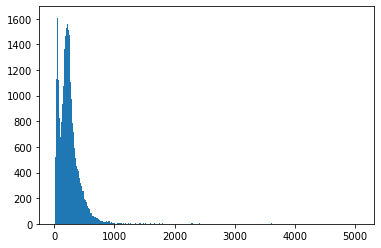

In [230]:
# plotting histogram of number of words in news shows that most news article are under 700 words.
# Lets keep each news small and truncate all news to 700 while tokenizing
plt.hist([len(x) for x in X], bins=500)
plt.show()

In [231]:
## Out of 44k news, 43k have less than 700 words
##nos = np.array([len(x) for x in X])
#len(nos[nos  < 700])

43352

In [233]:
# add padding to news text to generate vectors of equal sizes of 700 and truncate sentences longer than 700 words
maxlen = 700 

#Making all news of size maxlen defined above
X = pad_sequences(X, maxlen=maxlen)

In [234]:
# Embedding Layer creates one vector for "UNKNOWN" words, or padded words (0s). This Vector is filled with zeros.
# Thus vocab size inceeases by 1
vocab_size = len(tokenizer.word_index) + 1
vocab_size

122239

In [235]:
# Function to create weight matrix from word2vec gensim model
def get_weight_matrix(model, vocab):
    vocab_size = len(vocab) + 1
    weight_matrix = np.zeros((vocab_size, EMBEDDING_DIM))
    for word, i in vocab.items():
        weight_matrix[i] = model[word]
    return weight_matrix

In [236]:
#Getting embedding vectors from word2vec and usings it as weights of non-trainable keras embedding layer
embedding_vectors = get_weight_matrix(w2v_model, word_index)

In [237]:
#Train test split
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.20)

In [238]:
from sklearn.linear_model import LogisticRegression

LR = LogisticRegression()
LR.fit(x_train,y_train)
pred_lr=LR.predict(x_test)
print("Accuracy Score for Logistic Regression: {}".format(LR.score(x_test, y_test)))
print(classification_report(y_test, pred_lr))

Accuracy Score for Logistic Regression: 0.5920487915066637
              precision    recall  f1-score   support

           0       0.57      0.81      0.67      4560
           1       0.64      0.36      0.46      4294

    accuracy                           0.59      8854
   macro avg       0.61      0.59      0.57      8854
weighted avg       0.61      0.59      0.57      8854



In [239]:
from sklearn.tree import DecisionTreeClassifier

DT = DecisionTreeClassifier()
DT.fit(x_train, y_train)
pred_dt = DT.predict(x_test)
print("Accuracy Score for Decision Tree: {}".format(DT.score(x_test, y_test)))
print(classification_report(y_test, pred_dt))

Accuracy Score for Decision Tree: 0.8661621865823357
              precision    recall  f1-score   support

           0       0.84      0.91      0.87      4560
           1       0.90      0.82      0.86      4294

    accuracy                           0.87      8854
   macro avg       0.87      0.86      0.87      8854
weighted avg       0.87      0.87      0.87      8854



In [71]:
from sklearn.ensemble import GradientBoostingClassifier

GBC = GradientBoostingClassifier(random_state=0)
GBC.fit(x_train, y_train)
pred_gbc = GBC.predict(x_test)
print("Accuracy Score for Gradient Boost Classifier: {}".format(GBC.score(x_test, y_test)))
print(classification_report(y_test, pred_gbc))

Accuracy Score for Gradient Boost Classifier: 0.8294556132821324
              precision    recall  f1-score   support

           0       0.86      0.79      0.83      4527
           1       0.80      0.87      0.83      4327

    accuracy                           0.83      8854
   macro avg       0.83      0.83      0.83      8854
weighted avg       0.83      0.83      0.83      8854



In [72]:
from sklearn.ensemble import RandomForestClassifier

RFC = RandomForestClassifier(random_state=0)
RFC.fit(x_train, y_train)
pred_rfc = RFC.predict(x_test)
print("Accuracy Score for Random Forest Classifier: {}".format(RFC.score(x_test, y_test)))
print(classification_report(y_test, pred_rfc))

Accuracy Score for Random Forest Classifier: 0.825050824486108
              precision    recall  f1-score   support

           0       0.80      0.88      0.84      4527
           1       0.86      0.76      0.81      4327

    accuracy                           0.83      8854
   macro avg       0.83      0.82      0.82      8854
weighted avg       0.83      0.83      0.82      8854



In [247]:
# Defining LSTM Neural Network
model = Sequential()
model.add(Embedding(vocab_size, output_dim=EMBEDDING_DIM, weights=[embedding_vectors], input_length=maxlen, trainable=False))
model.add(LSTM(units=128))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
print(model.summary())
history=model.fit(x_train, y_train, validation_split=0.2, epochs=3, callbacks = [EarlyStopping(monitor='val_accuracy',min_delta=0.001,patience=2,verbose=1)])
y_pred = (model.predict(x_test) >= 0.5).astype("int")
print("Accuracy Score for Deep Neural Network with LSTM layer: {}".format(accuracy_score(y_test, y_pred)))
print(classification_report(y_test, y_pred))

Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_17 (Embedding)     (None, 700, 100)          12223900  
_________________________________________________________________
lstm_16 (LSTM)               (None, 128)               117248    
_________________________________________________________________
dropout_9 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_15 (Dense)             (None, 1)                 129       
Total params: 12,341,277
Trainable params: 117,377
Non-trainable params: 12,223,900
_________________________________________________________________
None
Epoch 1/3
886/886 [==============================] - 718s 808ms/step - loss: 0.1352 - accuracy: 0.9530 - val_loss: 0.0726 - val_accuracy: 0.9732
Epoch 2/3
886/886 [==============================] - 701s 791ms/step - loss: 0.0791

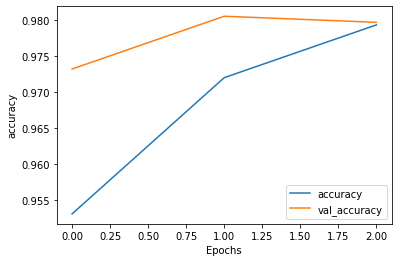

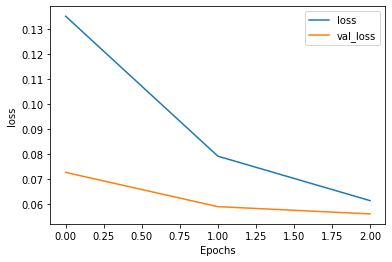

In [248]:
# plot the model accuracy and loss along with validation set accuracy and validation set loss
def plot_graphs(history, string):
        plt.plot(history.history[string])
        plt.plot(history.history['val_'+string])
        plt.xlabel("Epochs")
        plt.ylabel(string)
        plt.legend([string, 'val_'+string])
        plt.show()

plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

In [249]:
## Defining Bidirectional LSTM Neural Network
model1=Sequential()
model1.add(Embedding(vocab_size, output_dim=EMBEDDING_DIM, weights=[embedding_vectors], input_length=maxlen, trainable=False))
model1.add(Bidirectional(LSTM(100)))
model1.add(Dropout(0.3))
model1.add(Dense(1,activation='sigmoid'))
model1.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
print(model1.summary())
history=model1.fit(x_train, y_train, validation_split=0.2, epochs=5, callbacks = [EarlyStopping(monitor='val_accuracy',min_delta=0.001,patience=2,verbose=1)])
y_pred = (model1.predict(x_test) >= 0.5).astype("int")
print("Accuracy Score for Deep Neural Network with Bidirectional LSTM layer: {}".format(accuracy_score(y_test, y_pred)))
print(classification_report(y_test, y_pred))

Model: "sequential_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_18 (Embedding)     (None, 700, 100)          12223900  
_________________________________________________________________
bidirectional_4 (Bidirection (None, 200)               160800    
_________________________________________________________________
dropout_10 (Dropout)         (None, 200)               0         
_________________________________________________________________
dense_16 (Dense)             (None, 1)                 201       
Total params: 12,384,901
Trainable params: 161,001
Non-trainable params: 12,223,900
_________________________________________________________________
None
Epoch 1/5
886/886 [==============================] - 996s 1s/step - loss: 0.1273 - accuracy: 0.9548 - val_loss: 0.0624 - val_accuracy: 0.9780
Epoch 2/5
886/886 [==============================] - 981s 1s/step - loss: 0.0622 - acc

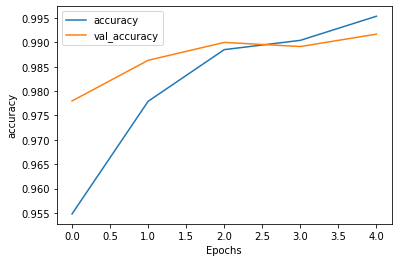

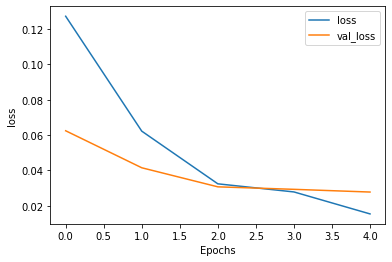

In [250]:
# plot the model accuracy and loss along with validation set accuracy and validation set loss
def plot_graphs(history, string):
        plt.plot(history.history[string])
        plt.plot(history.history['val_'+string])
        plt.xlabel("Epochs")
        plt.ylabel(string)
        plt.legend([string, 'val_'+string])
        plt.show()

plot_graphs(history, "accuracy")
plot_graphs(history, "loss")